# 一、简单线性回归模型实例

## 1.1 最小二乘法（解析解——矩阵求逆法求解）

### （1）导入相关包

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['simhei']
%matplotlib inline

### （2）导入数据集并探索数据

In [2]:
ex0 = pd.read_table('ex0.txt',header=None)

In [3]:
ex0.head()

,0,1,2
0,1.0,0.067732,3.176513
1,1.0,0.427810,3.816464
2,1.0,0.995731,4.550095
3,1.0,0.738336,4.256571
4,1.0,0.981083,4.560815


In [4]:
ex0.shape

(200, 3)

### （3）构建辅助函数

In [5]:
"""函数功能：输入DF数据集（最后一列为标签），返回特征矩阵和标签矩阵"""

def get_Mat(dataSet):
    xMat = np.mat(dataSet.iloc[:,:-1].values)
    yMat = np.mat(dataSet.iloc[:,-1].values).T
    return xMat,yMat

In [6]:
#查看函数运行结果
xMat,yMat=get_Mat(ex0)

In [7]:
xMat[:10]

matrix([[1.      , 0.067732],
        [1.      , 0.42781 ],
        [1.      , 0.995731],
        [1.      , 0.738336],
        [1.      , 0.981083],
        [1.      , 0.526171],
        [1.      , 0.378887],
        [1.      , 0.033859],
        [1.      , 0.132791],
        [1.      , 0.138306]])

In [8]:
yMat[:10]

matrix([[3.176513],
        [3.816464],
        [4.550095],
        [4.256571],
        [4.560815],
        [3.929515],
        [3.52617 ],
        [3.156393],
        [3.110301],
        [3.149813]])

In [9]:
"""函数功能：数据集可视化"""

def plotShow(dataSet):
    xMat,yMat=get_Mat(dataSet)
    plt.scatter(xMat.A[:,1],yMat.A,c='b',s=5)
    plt.show()

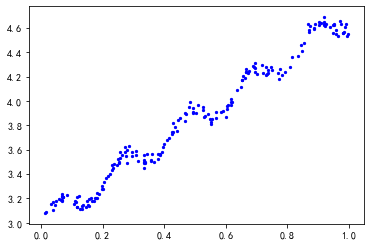

In [10]:
#可视化ex0数据集
plotShow(ex0)

### （4）计算回归系数

In [11]:
"""
函数功能：计算回归系数
参数说明：
    dataset:原始数据集
返回：
    ws:回归系数
"""
def standRegres(dataSet):
    xMat,yMat =get_Mat(dataSet)
    xTx = xMat.T*xMat
    if np.linalg.det(xTx)==0:                
        print('矩阵为奇异矩阵，无法求逆')
        return
    ws=xTx.I*(xMat.T*yMat)
    return ws

In [12]:
ws=standRegres(ex0)

In [13]:
ws

matrix([[3.00774324],
        [1.69532264]])

### （5）绘制最佳拟合直线

In [14]:
"""
函数功能：绘制散点图和最佳拟合直线
"""
def plotReg(dataSet):
    xMat,yMat=get_Mat(dataSet)
    plt.scatter(xMat.A[:,1],yMat.A,c='b',s=5)
    ws = standRegres(dataSet)
    yHat = xMat*ws
    plt.plot(xMat[:,1],yHat,c='r')
    plt.show()

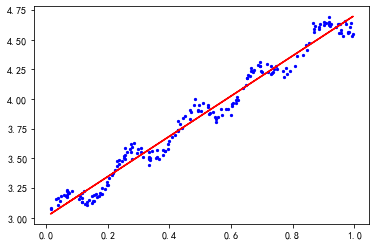

In [15]:
#绘制ex0数据集的散点图和最佳拟合直线
plotReg(ex0)

### （6）计算相关系数

In [16]:
xMat,yMat =get_Mat(ex0)
ws=standRegres(ex0)
yHat = xMat*ws
np.corrcoef(yHat.T,yMat.T) #保证两个都是行向量

array([[1.        , 0.98647356],
       [0.98647356, 1.        ]])

## 1.2 最小二乘法（近似解—梯度下降法求解）

## 1.2.1 Python中的线性回归

在线性回归中，我们希望对标量因变量$y$与一个或多个自变量（预测变量）$\boldsymbol{x}$之间的关系进行建模。

**给出** 
- 数据集 $\{(\boldsymbol{x}^{(1)}, y^{(1)}), ..., (\boldsymbol{x}^{(m)}, y^{(m)})\}$
-  $\boldsymbol{x}^{(i)}$ 变成一个 $d-$维向量 $\boldsymbol{x}^i = (x^{(i)}_1, ..., x^{(i)}_d)$
- $y^{(i)}$ 作为目标变量

线性回归模型可以解释为非常简单的**神经网络**：
- 实值权重向量（weight vector） $\boldsymbol{w}= (w^{(1)}, ..., w^{(d)})$
- 实值偏差（valued bias）$b$
- 使用恒等函数作为其激活函数（activation function）

![title](linear_regression.jpg)

## 1.2.2 训练模型

线性回归模型可以使用  
a) 梯度下降法或者  
b)正态方程（闭式解）: $\boldsymbol{w} = (\boldsymbol{X}^T \boldsymbol{X})^{-1} \boldsymbol{X}^T \boldsymbol{y}$ 


其中 $\boldsymbol{X}$ 是形状为$(m, n_{特征})$ 的矩阵，其中包含所有训练示例。
正态方程需要计算 $\boldsymbol{X}^T\boldsymbol{X}$ 的逆。 此操作的计算复杂度在 $O(n_{特征}^3$) 之间（取决于实现方式）。
因此，如果训练集中的特征数量很大，则正规方程将变得非常慢。

* * *
线性回归模型的训练过程具有不同的步骤。 首先（步骤0）初始化模型参数。 重复其他步骤（请参阅下文）以进行指定次数的训练迭代，或者直到参数收敛为止。

**步骤0:** 

初始化权重向量并使用零（或小的随机值）进行偏置

**或者**

使用正态方程直接计算参数
* * *

**步骤1:** （仅当使用梯度下降训练时才需要）

计算输入特征和权重的线性组合。对于所有训练样本，可以使用**vectorization and broadcasting**一步完成：
$\boldsymbol{\hat{y}} = \boldsymbol{X} \cdot \boldsymbol{w} + b $

其中 $\boldsymbol{X}$ 是形状 $(m, n_{特征})$ 的矩阵，其中包含所有训练示例，而 $\cdot$ 表示点积。

* * *

**步骤2:** （仅当使用梯度下降训练时才需要）

计算训练集上的损失（均方误差）：

$J(\boldsymbol{w},b) = \frac{1}{m} \sum_{i=1}^m \Big(\hat{y}^{(i)} - y^{(i)} \Big)^2$
* * *

**步骤3:** （仅当使用梯度下降训练时才需要）

针对每个参数计算损失函数的偏导数：

$ \frac{\partial J}{\partial w_j} = \frac{2}{m}\sum_{i=1}^m \Big( \hat{y}^{(i)} - y^{(i)} \Big) x^{(i)}_j$

$ \frac{\partial J}{\partial b} = \frac{2}{m}\sum_{i=1}^m \Big( \hat{y}^{(i)} - y^{(i)} \Big)$


然后可以计算包含所有偏导数的梯度，如下所示： 

$\nabla_{\boldsymbol{w}} J = \frac{2}{m} \boldsymbol{X}^T \cdot \big(\boldsymbol{\hat{y}} - \boldsymbol{y} \big)$

$\nabla_{\boldsymbol{b}} J = \frac{2}{m} \big(\boldsymbol{\hat{y}} - \boldsymbol{y} \big)$
* * *

**步骤4:** （仅当使用梯度下降训练时才需要）

更新权重向量和偏差：

$\boldsymbol{w} = \boldsymbol{w} - \eta \, \nabla_w J$  

$b = b - \eta \, \nabla_b J$  


其中 $\eta$ 是学习率.

### （1）导入相关包

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(123)

### （2）导入数据集并探索数据

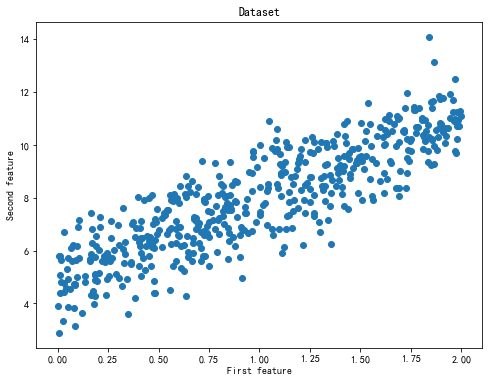

In [18]:
# 我们将使用一个简单的训练集，将生成的随机数作为输入
X = 2 * np.random.rand(500, 1)
y = 5 + 3 * X + np.random.randn(500, 1)

fig = plt.figure(figsize=(8,6))
plt.scatter(X, y)
plt.title("Dataset")
plt.xlabel("First feature")
plt.ylabel("Second feature")
plt.show()

### （3）将数据分成训练和测试集

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f'Shape X_train: {X_train.shape}')
print(f'Shape y_train: {y_train.shape}')
print(f'Shape X_test: {X_test.shape}')
print(f'Shape y_test: {y_test.shape}')

Shape X_train: (375, 1)
Shape y_train: (375, 1)
Shape X_test: (125, 1)
Shape y_test: (125, 1)


### （4）线性回归模型的训练过程

In [20]:
class LinearRegression:
    
    def __init__(self):
        pass

    def train_gradient_descent(self, X, y, learning_rate=0.01, n_iters=100):
        """
       使用梯度下降训练线性回归模型
        """
        # 步骤0：初始化参数
        n_samples, n_features = X.shape
        self.weights = np.zeros(shape=(n_features,1))
        self.bias = 0
        costs = []

        for i in range(n_iters):
            # 步骤1：计算输入特征和权重的线性组合
            y_predict = np.dot(X, self.weights) + self.bias

            # 步骤2: 计算训练集上的损失
            cost = (1 / n_samples) * np.sum((y_predict - y)**2)
            costs.append(cost)

            if i % 100 == 0:
                print(f"Cost at iteration {i}: {cost}")

            # 步骤3：计算梯度
            dJ_dw = (2 / n_samples) * np.dot(X.T, (y_predict - y))
            dJ_db = (2 / n_samples) * np.sum((y_predict - y)) 
            
            # 步骤四：更新参数
            self.weights = self.weights - learning_rate * dJ_dw
            self.bias = self.bias - learning_rate * dJ_db

        return self.weights, self.bias, costs

    def train_normal_equation(self, X, y):
        """
        训练正态方程训练线性回归模型
        """
        self.weights = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
        self.bias = 0
        
        return self.weights, self.bias

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

### （5）使用梯度下降法训练

Cost at iteration 0: 66.45256981003433
Cost at iteration 100: 2.208434614609594
Cost at iteration 200: 1.2797812854182806
Cost at iteration 300: 1.2042189195356685
Cost at iteration 400: 1.1564867816573
Cost at iteration 500: 1.121391041394467


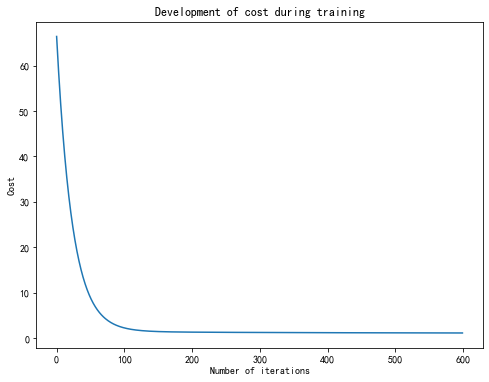

In [21]:
regressor = LinearRegression()
w_trained, b_trained, costs = regressor.train_gradient_descent(X_train, y_train, learning_rate=0.005, n_iters=600)

fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(600), costs)
plt.title("Development of cost during training")
plt.xlabel("Number of iterations")
plt.ylabel("Cost")
plt.show()

### （6）测试梯度下降模型

In [22]:
n_samples, _ = X_train.shape
n_samples_test, _ = X_test.shape

y_p_train = regressor.predict(X_train)
y_p_test = regressor.predict(X_test)

error_train =  (1 / n_samples) * np.sum((y_p_train - y_train) ** 2)
error_test =  (1 / n_samples_test) * np.sum((y_p_test - y_test) ** 2)

print(f"Error on training set: {np.round(error_train, 4)}")
print(f"Error on test set: {np.round(error_test)}")

Error on training set: 1.0955
Error on test set: 1.0


### （7）使用正态方程训练

In [23]:
# 要使用正态方程计算参数，我们向每个输入示例添加一个偏置值1

X_b_train = np.c_[np.ones((n_samples)), X_train]
X_b_test = np.c_[np.ones((n_samples_test)), X_test]

reg_normal = LinearRegression()
w_trained = reg_normal.train_normal_equation(X_b_train, y_train)

### （7）测试正态方程

In [24]:
y_p_train = reg_normal.predict(X_b_train)
y_p_test = reg_normal.predict(X_b_test)

error_train =  (1 / n_samples) * np.sum((y_p_train - y_train) ** 2)
error_test =  (1 / n_samples_test) * np.sum((y_p_test - y_test) ** 2)

print(f"Error on training set: {np.round(error_train, 4)}")
print(f"Error on test set: {np.round(error_test, 4)}")

Error on training set: 1.0228
Error on test set: 1.0432


### （8） 测试结果可视化

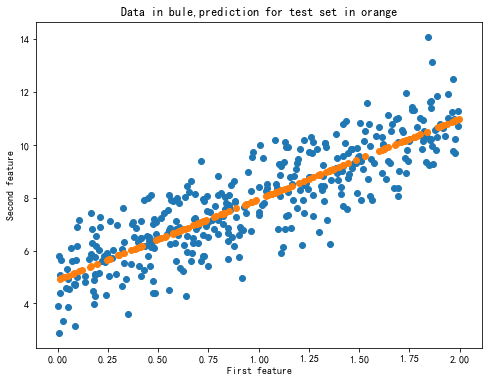

In [25]:
# 绘制测试结果

fig = plt.figure(figsize=(8,6))
plt.title("Data in bule,prediction for test set in orange")
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_p_test)
plt.xlabel("First feature")
plt.ylabel("Second feature")
plt.show()